### 고령자 비율이 높은 지역일수록 고령자 교통사고 발생 빈도가 높다.

귀무가설(H0): 고령자 비율은 고령자 교통사고 피해자 수와 관련이 없다.
<br>
<br>
대립가설(H1): 고령자 비율은 고령자 교통사고 피해자 수와 관련이 있다.

In [1]:
# 라이브러리 호출 및 plot 설정
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from rapidfuzz import process, fuzz
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
import warnings

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")

In [2]:
df_total = pd.read_csv('../../data/preprocessed_data/시도_시군구별_보행자_사고_사고유형_전처리ver.csv')
# df_total
HTML(df_total.head().to_html())

,연도,시군구,법정동코드,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,도로형태,피해자 상해정도
0,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로부근,중상
1,2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로안,중상
2,2020,서울특별시 종로구 통인동,1111010800,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상
3,2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 차도통행중,교차로 - 교차로안,경상
4,2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상


In [3]:
df_elderly_rate = pd.read_csv('../../data/preprocessed_data/시군구_고령자_비율_전처리ver.csv')
# df_elderly_rate
HTML(df_elderly_rate.head().to_html())

,연도,시군구,법정동코드,총 인구,고령자 수,고령자 비율 (%),시군구명
0,2020,서울특별시 종로구,1111000000,149384,28311,19,서울특별시 종로구
1,2020,서울특별시 중구,1114000000,125240,24174,19.3,서울특별시 중구
2,2020,서울특별시 용산구,1117000000,230040,39779,17.3,서울특별시 용산구
3,2020,서울특별시 성동구,1120000000,293556,45435,15.5,서울특별시 성동구
4,2020,서울특별시 광진구,1121500000,346682,50311,14.5,서울특별시 광진구


In [4]:
# 숫자로 변환 불가능한 값들 확인
non_numeric = df_elderly_rate[~df_elderly_rate['고령자 비율 (%)'].str.replace('.', '', regex=False).str.isnumeric()]
print(non_numeric['고령자 비율 (%)'].unique())

['-']


In [5]:
# 총 인구, 고량자 수, 고령자 비율 결측을 0으로 처리
df_elderly_rate['고령자 비율 (%)'] = pd.to_numeric(df_elderly_rate['고령자 비율 (%)'], errors='coerce').fillna(0)
df_elderly_rate['총 인구'] = pd.to_numeric(df_elderly_rate['총 인구'], errors='coerce').fillna(0)
df_elderly_rate['고령자 수'] = pd.to_numeric(df_elderly_rate['고령자 수'], errors='coerce').fillna(0)


# 평균 계산 (시군구 기준)
df_elderly_avg = (
    df_elderly_rate
    .groupby('시군구')[['총 인구', '고령자 수', '고령자 비율 (%)']]
    .mean()
    .reset_index()
)

# 정리: 소수점 반올림 및 타입 정리
df_elderly_avg['총 인구'] = df_elderly_avg['총 인구'].round().astype(int)
df_elderly_avg['고령자 수'] = df_elderly_avg['고령자 수'].round().astype(int)
df_elderly_avg['고령자 비율 (%)'] = df_elderly_avg['고령자 비율 (%)'].round(2)

# 내림차순 정렬
df_elderly_avg_sorted = df_elderly_avg.sort_values(by='고령자 비율 (%)', ascending=False)
df_elderly_avg_sorted.set_index('시군구', inplace=True)
df_elderly_avg_sorted.reset_index(inplace=True)

# 결과 확인
df_elderly_avg_sorted.head()

,시군구,총 인구,고령자 수,고령자 비율 (%)
0,경상북도 의성군,50264,22279,44.38
1,전라남도 고흥군,61973,26816,43.30
2,경상남도 합천군,42102,17781,42.30
3,전라남도 보성군,38612,15870,41.16
4,경상북도 청도군,41533,16935,40.82


In [6]:
def get_victim_stats_by_city_district(df):
    """
    시군구에서 '세종특별자치시 XXX'는 '세종특별자치시'로
    그 외는 앞 2단어(예: '서울특별시 동대문구')로 추출하여
    피해자 수(총합 + 유형별)를 합산한 데이터프레임 반환
    """
    df = df.copy()

    # 시군구 요약 처리
    def normalize_city_district(name):
        if isinstance(name, str) and name.startswith('세종특별자치시'):
            return '세종특별자치시'
        elif isinstance(name, str):
            return ' '.join(name.split()[:2])
        return name

    df['시군구'] = df['시군구'].apply(normalize_city_district)

    # Null 값 0으로 처리
    for col in ['사망자수', '중상자수', '경상자수', '부상신고자수']:
        df[col] = df[col].fillna(0)

    # 피해자 수 총합 계산
    df['피해자수'] = (
        df['사망자수'] +
        df['중상자수'] +
        df['경상자수'] +
        df['부상신고자수']
    )

    # 시군구 기준 그룹화
    summary = df.groupby('시군구').agg({
        '사망자수': 'sum',
        '중상자수': 'sum',
        '경상자수': 'sum',
        '부상신고자수': 'sum',
        '피해자수': 'sum'
    }).reset_index()

    # 피해자 수 기준 정렬
    summary = summary.sort_values(by='피해자수', ascending=False)

    return summary

In [7]:
victim_summary_df = get_victim_stats_by_city_district(df_total)
victim_summary_df.set_index('시군구', inplace=True)
victim_summary_df.reset_index(inplace=True)
victim_summary_df

,시군구,사망자수,중상자수,경상자수,부상신고자수,피해자수
0,경기도 수원시,35,493,479,55,1062
1,경상남도 창원시,61,562,317,42,982
2,경기도 부천시,27,449,451,35,962
3,경기도 고양시,41,371,325,62,799
4,경기도 성남시,22,394,314,68,798
...,...,...,...,...,...,...
257,강원특별자치도 철원군,1,4,2,0,7
258,강원특별자치도 고성군,2,3,1,0,6
259,강원특별자치도 화천군,0,5,0,1,6
260,전북특별자치도 진안군,1,4,0,1,6


In [8]:
# 지역명 통일
replace_dict = {
    '강원특별자치도': '강원도',
    '전북특별자치도': '전라북도',
}

# 시도명 표준화
def standardize_region_name(region_name):
    for old, new in replace_dict.items():
        if region_name.startswith(old):
            return region_name.replace(old, new, 1)
    return region_name

victim_summary_df['시군구'] = victim_summary_df['시군구'].apply(standardize_region_name)
victim_summary_df

,시군구,사망자수,중상자수,경상자수,부상신고자수,피해자수
0,경기도 수원시,35,493,479,55,1062
1,경상남도 창원시,61,562,317,42,982
2,경기도 부천시,27,449,451,35,962
3,경기도 고양시,41,371,325,62,799
4,경기도 성남시,22,394,314,68,798
...,...,...,...,...,...,...
257,강원도 철원군,1,4,2,0,7
258,강원도 고성군,2,3,1,0,6
259,강원도 화천군,0,5,0,1,6
260,전라북도 진안군,1,4,0,1,6


In [ ]:
elderly_regions = set(df_elderly_avg_sorted['시군구'].unique())
victim_regions = set(victim_summary_df['시군구'].unique())

only_in_elderly = elderly_regions - victim_regions   # 고령자 데이터에는 있지만 피해자 데이터에는 없는 지역
only_in_victim = victim_regions - elderly_regions    # 피해자 데이터에는 있지만 고령자 데이터에는 없는 지역

# 결과 확인
print("고령자 데이터에만 있는 시군구:")
print(sorted(only_in_elderly))
print("\n피해자 데이터에만 있는 시군구:")
print(sorted(only_in_victim))

고령자 데이터에만 있는 시군구:
[]

피해자 데이터에만 있는 시군구:
[]


In [10]:
# 일치 결과 저장 리스트
mapping = []

for i, row in df_elderly_avg_sorted.iterrows():
    elderly_region = row['시군구']
    best_match, score, _ = process.extractOne(
        elderly_region,
        victim_summary_df['시군구'],
        scorer=fuzz.token_sort_ratio
    )

    if score >= 80:  # 유사도 기준
        victim_row = victim_summary_df[victim_summary_df['시군구'] == best_match].iloc[0]
        merged_row = {
            '시군구': elderly_region,
            '고령자 비율 (%)': row['고령자 비율 (%)'],
            '총 인구': row['총 인구'],
            '고령자 수': row['고령자 수'],
            '사망자수': victim_row['사망자수'],
            '중상자수': victim_row['중상자수'],
            '경상자수': victim_row['경상자수'],
            '부상신고자수': victim_row['부상신고자수'],
            '피해자수': victim_row['피해자수']
        }
        mapping.append(merged_row)

# 매핑된 데이터프레임 생성
df_merged = pd.DataFrame(mapping)
# df_merged
HTML(df_merged.head(5).to_html(index=False))

시군구,고령자 비율 (%),총 인구,고령자 수,사망자수,중상자수,경상자수,부상신고자수,피해자수
경상북도 의성군,44.38,50264,22279,16,57,31,1,105
전라남도 고흥군,43.30,61973,26816,9,84,46,0,139
경상남도 합천군,42.30,42102,17781,8,54,19,7,88
전라남도 보성군,41.16,38612,15870,10,37,36,2,85
경상북도 청도군,40.82,41533,16935,7,39,23,2,71


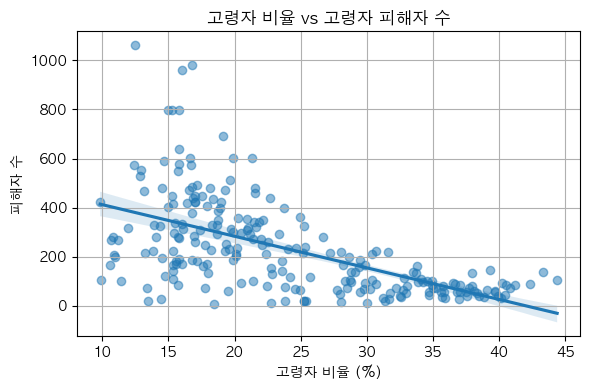

In [11]:
# 고령자 비율 대비 고령자 피해자 수 확인
plt.figure(figsize=(6, 4))
sns.regplot(data=df_merged, x='고령자 비율 (%)', y='피해자수', scatter_kws={'alpha':0.5})
plt.title("고령자 비율 vs 고령자 피해자 수")
plt.xlabel("고령자 비율 (%)")
plt.ylabel("피해자 수")
plt.grid(True)
plt.tight_layout()
plt.show()

# save_path = '../../outputs/가설_2/고령자_비율_대비_고령자_피해자_수.png'
# plt.savefig(save_path)

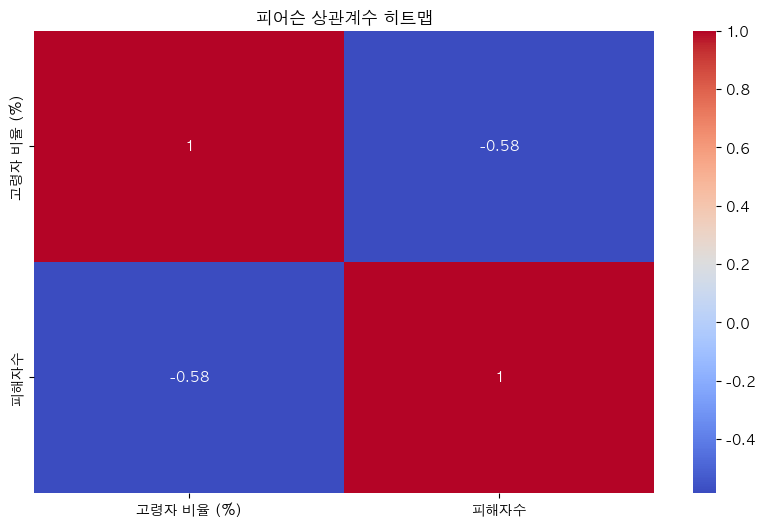

<Figure size 640x480 with 0 Axes>

In [20]:
# 피어슨 상관 계수 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(df_merged[['고령자 비율 (%)', '피해자수']].corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('피어슨 상관계수 히트맵')
plt.show()

# save_path = '../../outputs/가설_2/피어슨_상관계수_히트맵.png'
# plt.savefig(save_path)

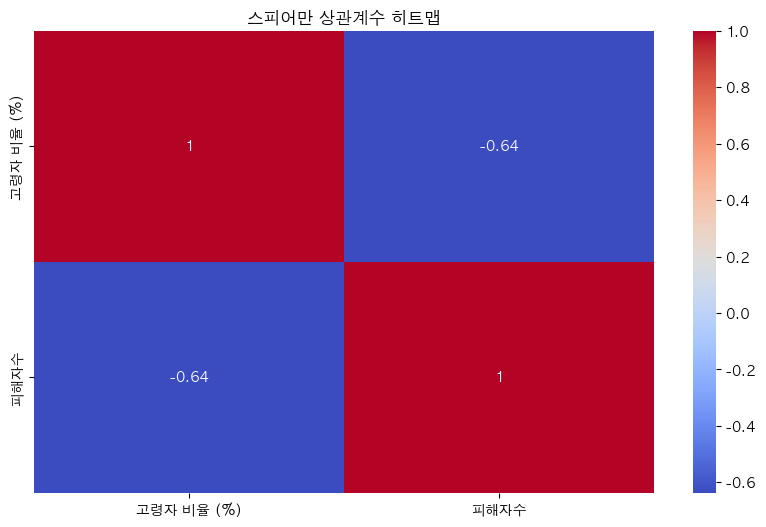

<Figure size 640x480 with 0 Axes>

In [21]:
# 스피어만 상관 계수 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(df_merged[['고령자 비율 (%)', '피해자수']].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('스피어만 상관계수 히트맵')
plt.show()

# save_path = '../../outputs/가설_2/스피어만_상관계수_히트맵.png'
# plt.savefig(save_path)

In [ ]:
corr, p = pearsonr(df_merged['고령자 비율 (%)'], df_merged['피해자수'])
print(f'피어슨 상관계수: {corr:.3f}, p-value: {p:.30f}')

# =================================================
# 음의 상관관계. 고령자 비율이 높을수록 피해자 수는 오히려 감소
# p-value < 0.05이므로, 통계적으로 유의
# =================================================

피어슨 상관계수: -0.584, p-value: 0.000000000000000000000210816590


In [ ]:
corr, p = spearmanr(df_merged['고령자 비율 (%)'], df_merged['피해자수'])
print(f'스피어만 상관계수: {corr:.3f}, p-value: {p:.30f}')

# =================================================
# 음의 상관관계. 고령자 비율이 높을수록 피해자 수는 오히려 감소
# p-value < 0.05이므로, 통계적으로 유의
# 귀무가설 기각
# =================================================

스피어만 상관계수: -0.637, p-value: 0.000000000000000000000000001466


In [ ]:
X = df_merged['고령자 비율 (%)']
y = df_merged['피해자수']
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()
print(model.summary())

# ======================================================================================================================
# 고령자 비율이 1% 증가할 때, 피해자 수는 평균적으로 약 12.88명 감소
# p-value는 0.000이므로, 회귀계수가 유의미
# 귀무가설 기각
# 결정계수(R²)=0.341 -> 고령자 비율만으로 고령자 피해자 수의 약 34.1%를 설명 가능. 나머지는 고령자 절대 수, 차량 수, 인구 밀도 등에 의해 설명 가능.
# ======================================================================================================================

                            OLS Regression Results                            
Dep. Variable:                   피해자수   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     117.9
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           2.11e-22
Time:                        22:59:19   Log-Likelihood:                -1488.6
No. Observations:                 230   AIC:                             2981.
Df Residuals:                     228   BIC:                             2988.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        540.9925     30.362     17.818      0.0